# Imports

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.1 MB/s eta 0:00:00


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from xgboost import XGBRegressor
import xgboost as xgb

import catboost as cb
import missingno as msno

import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Update path as necessary
train = '/content/drive/MyDrive/DS4B/Ames/train.csv'
cleaned_norm = '/content/drive/MyDrive/DS4B/Ames/cleaned_norm.csv'

#Run feature selection in Lasso, export csv, then update path as necessary
cleaned_norm_selected = '/content/drive/MyDrive/DS4B/Ames/cleaned_norm_selected.csv'

# Linear Regression

## All Features

In [ ]:
df = pd.read_csv(cleaned_norm)
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Linear Regression Performance:")
print(f'RMSE: {rmse:.3f}')
print(f'R² Score: {r2:.3f}')

Linear Regression Performance:
RMSE: 1301863859780180.500
R² Score: -277549367930914799616.000


## Highly Correlated Features

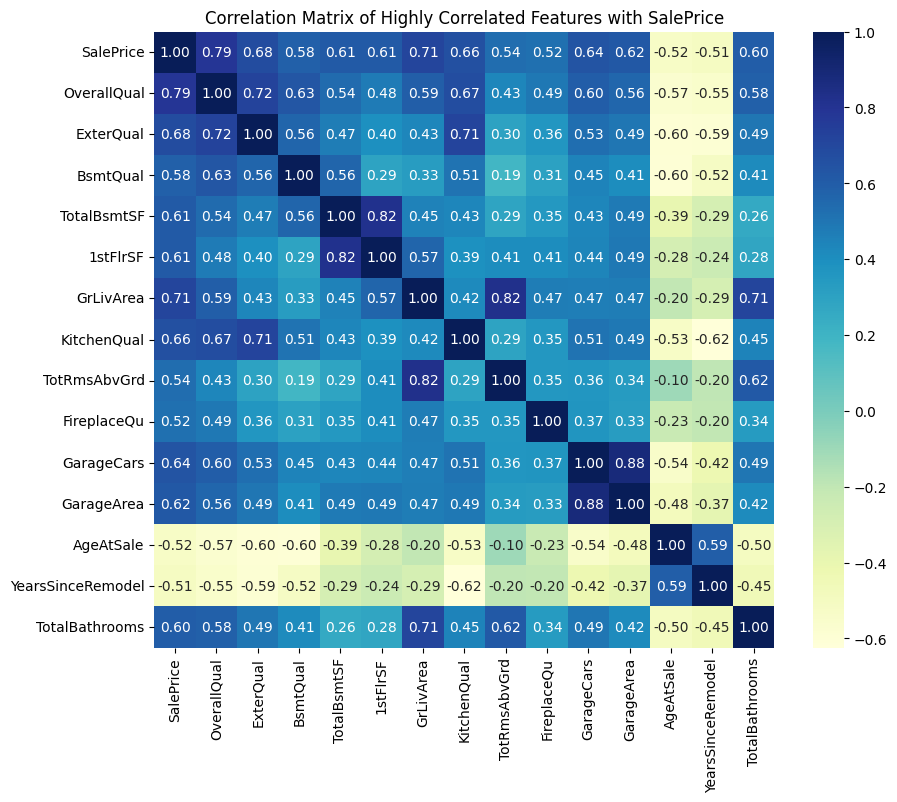

In [ ]:
df = pd.read_csv(cleaned_norm)

corr_matrix = df.corr(method='pearson').round(3)
high_corr_features = corr_matrix.index[abs(corr_matrix["SalePrice"]) > 0.5]

ordered_features = ['SalePrice'] + [feature for feature in high_corr_features if feature != 'SalePrice']
high_corr_matrix = corr_matrix.loc[ordered_features, ordered_features]

plt.figure(figsize=(10, 8))
sns.heatmap(high_corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Correlation Matrix of Highly Correlated Features with SalePrice')
plt.show()

In [ ]:
X = df[high_corr_features].drop('SalePrice', axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Linear Regression on Highly Correlated Features Performance:")
print(f'RMSE: {rmse:.3f}')
print(f'R² Score: {r2:.3f}')

Linear Regression on Highly Correlated Features Performance:
RMSE: 30892.240
R² Score: 0.844


#Lasso Regression for Feature Selection

In [ ]:
df = pd.read_csv(cleaned_norm)
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define alpha values to be searched
alphas = np.logspace(-4, 4, 9)  # Range from 0.0001 to 10000

# Lasso Regression
lasso_param_grid = {'alpha': alphas}
lasso_grid = GridSearchCV(Lasso(tol=0.1), lasso_param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)

# Best alpha values
print("Best parameters:", lasso_grid.best_params_)

# Best models
best_lasso_model = lasso_grid.best_estimator_

# Predictions
lasso_preds = best_lasso_model.predict(X_test)

# RMSE
lasso_rmse = mean_squared_error(y_test, lasso_preds, squared=False)

# R-squared (R^2) Score
lasso_r2 = r2_score(y_test, lasso_preds)

print("Lasso Regression Performance:")
print(f'RMSE: {lasso_rmse:.3f}')
print(f'R² Score: {lasso_r2:.3f}')


Best parameters: {'alpha': 100.0}
Lasso Regression Performance:
RMSE: 27854.352
R² Score: 0.873


In [ ]:
# Export best lasso model
lasso_model = Lasso(alpha=lasso_grid.best_params_['alpha'])
lasso_model.fit(X_train, y_train)

Lasso(alpha=100.0)

In [ ]:
non_zero_count = np.count_nonzero(lasso_model.coef_)
print("Number of non-zero coefficients:", non_zero_count)
print("Total coefficients:", len(lasso_model.coef_))

Number of non-zero coefficients: 88
Total coefficients: 213


In [ ]:
# Get the coefficients from the Lasso model
lasso_coefs = lasso_model.coef_

# Get the column names from df_final
column_names = X_train.columns

# Create a DataFrame to store the non-zero coefficient columns
selected_columns = pd.DataFrame({'Feature': column_names, 'Coefficient': lasso_coefs})

# Filter the columns where the coefficient is non-zero
selected_columns = selected_columns[selected_columns['Coefficient'] != 0]

# Extract the feature names with non-zero coefficients
selected_feature_names = selected_columns['Feature']

# Create the new DataFrame with selected columns
selected_df = df[selected_feature_names].copy()

selected_df['SalePrice'] = df['SalePrice']

In [ ]:
selected_df.columns

Index(['LotArea', 'LandSlope', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtUnfSF', 'HeatingQC', '2ndFlrSF', 'GrLivArea',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageCars', 'WoodDeckSF',
       'MoSold', 'GarageFinish_RFn', 'GarageFinish_Unf', 'MasVnrType_BrkCmn',
       'MasVnrType_BrkFace', 'MSZoning_FV', 'MSZoning_RL', 'LandContour_HLS',
       'LandContour_Low', 'LandContour_Lvl', 'LotConfig_CulDSac',
       'LotConfig_FR2', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Veenker',
       'Condition1_Fee

In [ ]:
# Filter the coefficients where the coefficient is non-zero
non_zero_coefficients = selected_columns[selected_columns['Coefficient'] != 0].copy()

# Calculate the absolute values of coefficients
non_zero_coefficients['Absolute_Coefficient'] = non_zero_coefficients['Coefficient'].abs()

# Determine if the coefficient is positive or negative
non_zero_coefficients['Positive_or_Negative'] = non_zero_coefficients['Coefficient'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

# Sort the selected features by absolute coefficient values in descending order
selected_features_sorted = non_zero_coefficients.sort_values(by='Absolute_Coefficient', ascending=False)

# Print the selected features along with their coefficients
print("Selected Features and Coefficients:")
selected_features_sorted

Selected Features and Coefficients:


,Feature,Coefficient,Absolute_Coefficient,Positive_or_Negative
22,GrLivArea,206262.333776,206262.333776,Positive
132,RoofMatl_WdShngl,93827.657581,93827.657581,Positive
4,OverallQual,88413.676229,88413.676229,Positive
106,Condition2_PosN,-80290.103042,80290.103042,Negative
6,MasVnrArea,50841.658666,50841.658666,Positive
...,...,...,...,...
23,BedroomAbvGr,-784.008160,784.008160,Negative
206,MSSubClass_90,-502.084738,502.084738,Negative
29,FireplaceQu,498.843649,498.843649,Positive
64,LandContour_Low,283.184857,283.184857,Positive


In [ ]:
selected_df.to_csv("cleaned_norm_selected.csv", index=False)

#RFE feature selection

In [ ]:
df = pd.read_csv(cleaned_norm)
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Setup RFE with cross-validation to find the optimal number of features automatically
rfe = RFECV(estimator=model, step=1, cv=3, scoring='neg_mean_squared_error')

# Fit RFE
rfe.fit(X_train, y_train)

# Transform the data
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Train a new model on the reduced set of features
model.fit(X_train_selected, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test_selected)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Optimal number of features: {rfe.n_features_}')
print(f'Selected features: {X.columns[rfe.support_]}')
print(f'\nRMSE: {rmse:.3f}')
print(f'R² Score: {r2:.3f}')

Optimal number of features: 5
Selected features: Index(['OverallQual', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv',
       'RoofMatl_WdShngl'],
      dtype='object')

RMSE: 45275.708
R² Score: 0.664


# PCA

In [ ]:
df = pd.read_csv(cleaned_norm)
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

components_range = range(1, len(X.columns))
r2_scores = []
rmse_scores = []

for n in components_range:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Initialize and train Linear Regression Model
    model = LinearRegression()
    model.fit(X_train_pca, y_train)

    y_pred = model.predict(X_test_pca)

    # Evaluate the model with R²
    r2 = model.score(X_test_pca, y_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2_scores.append(r2)
    rmse_scores.append(rmse)

print(f"Best R^2 Score: {r2_scores[np.argmax(r2_scores)]:.3f}")
print("Optimal number of components by R²:", components_range[np.argmax(r2_scores)])
print(f"\nBest RMSE:: {rmse_scores[np.argmin(rmse_scores)]:.3f}")
print("Optimal number of components by RMSE:", components_range[np.argmin(rmse_scores)])

Best R^2 Score: 0.873
Optimal number of components by R²: 91

Best RMSE:: 27859.706
Optimal number of components by RMSE: 91


#Random Forest

##All features

In [ ]:
df = pd.read_csv(cleaned_norm)
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Setup parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['sqrt', 'log2', 0.5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Perform GridSearchCV
grid_search.fit(X_train, y_train)

# Best model
print("Best parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Best parameters: {'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters: {'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
# Initialize Random Forest Regressor with best parameters
best_rf_model = RandomForestRegressor(max_depth=15,
                              max_features=0.5,
                              min_samples_leaf=1,
                              min_samples_split=2,
                              n_estimators=300,
                              random_state=42)

# Train the model
best_rf_model.fit(X_train, y_train)

# Predict the house prices
y_pred = best_rf_model.predict(X_test)

# Calculate the R² score
r2 = r2_score(y_test, y_pred)

# Calculate the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Random Forest Performance on all Features:")
print(f'\nRMSE: {rmse:.3f}')
print(f'R² Score: {r2:.3f}')

Random Forest Performance on Selected Features:

RMSE: 24398.404
R² Score: 0.903


##Selected features

In [ ]:
df = pd.read_csv(cleaned_norm_selected)
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Setup parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['sqrt', 'log2', 0.5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Perform GridSearchCV
grid_search.fit(X_train, y_train)

# Best model
print("Best parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Best parameters: {'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters: {'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# Initialize Random Forest Regressor with best parameters
best_rf_model = RandomForestRegressor(max_depth=15,
                              max_features=0.5,
                              min_samples_leaf=1,
                              min_samples_split=2,
                              n_estimators=200,
                              random_state=42)

# Train the model
best_rf_model.fit(X_train, y_train)

# Predict the house prices
y_pred = best_rf_model.predict(X_test)

# Calculate the R² score
r2 = r2_score(y_test, y_pred)

# Calculate the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Random Forest Performance on Selected Features:")
print(f'\nRMSE: {rmse:.3f}')
print(f'R² Score: {r2:.3f}')

Random Forest Performance on Selected Features:

RMSE: 25930.914
R² Score: 0.890


#SVM

##All features

In [ ]:
df = pd.read_csv(cleaned_norm)
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the SVR model
svm_model = SVR()

# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly']  # Type of kernel
}

# Setup GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)
best_svm_model = grid_search.best_estimator_

# Use the best model to make predictions
y_pred = best_svm_model.predict(X_test)

# Calculate R² - This is the coefficient of determination
r2 = r2_score(y_test, y_pred)

# Calculate RMSE - This is the root mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("SVM Performance:")
print(f'\nRMSE: {rmse:.3f}')
print(f'R² Score: {r2:.3f}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
SVM Performance:

RMSE: 52399.196
R² Score: 0.550


##Selected features

In [ ]:
df = pd.read_csv(cleaned_norm_selected)
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the SVR model
svm_model = SVR()

# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly']  # Type of kernel
}

# Setup GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)
best_svm_model = grid_search.best_estimator_

# Use the best model to make predictions
y_pred = best_svm_model.predict(X_test)

# Calculate R² - This is the coefficient of determination
r2 = r2_score(y_test, y_pred)

# Calculate RMSE - This is the root mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("SVM Performance on Selected Features:")
print(f'\nRMSE: {rmse:.3f}')
print(f'R² Score: {r2:.3f}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
SVM Performance on Selected Features:

RMSE: 56310.403
R² Score: 0.481


#Neural Network

##All features

In [ ]:
df = pd.read_csv(cleaned_norm)
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the target
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

print("Number of parameters:")
model.summary()

# Train the model
model.fit(X_train, y_train_scaled, epochs=100, batch_size=10, verbose=1)

# Predict the house prices
y_pred_scaled = model.predict(X_test).flatten()

# Inverse transform the predictions to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Calculate the R² score
r2 = r2_score(y_test, y_pred)

# Calculate the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Neural Net Performance:")
print(f'\nRMSE: {rmse:.3f}')
print(f'R² Score: {r2:.3f}')

Number of parameters:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               27392     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 37761 (147.50 KB)
Trainable params: 37761 (147.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
117/117 [==============================] - 1s 2ms/step - loss: 0.0079
Epoch 2/100
117/117 [=========================

##Selected features

In [ ]:
df = pd.read_csv(cleaned_norm_selected)
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the target
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

print("Number of parameters:")
model.summary()

# Train the model
model.fit(X_train, y_train_scaled, epochs=100, batch_size=10, verbose=1)

# Predict the house prices
y_pred_scaled = model.predict(X_test).flatten()

# Inverse transform the predictions to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Calculate the R² score
r2 = r2_score(y_test, y_pred)

# Calculate the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Neural Net Performance on Selected Features:")
print(f'\nRMSE: {rmse:.3f}')
print(f'R² Score: {r2:.3f}')

Number of parameters:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               11392     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21761 (85.00 KB)
Trainable params: 21761 (85.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
117/117 [==============================] - 1s 2ms/step - loss: 0.0143
Epoch 2/100
117/117 [=========================

#XGBoost

##All features

In [ ]:
data = pd.read_csv(cleaned_norm)
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

model = XGBRegressor(objective='reg:squarederror')

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1}

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1}


In [ ]:
# Initialize XGBoostRegressor
model = xgb.XGBRegressor(colsample_bytree= 0.8,
                        learning_rate= 0.05,
                        max_depth= 3,
                        n_estimators= 300,
                        subsample= 1,
                        objective='reg:squarederror')

# Train the model
model.fit(X_train, y_train)

# Use the best model to make predictions
y_pred = model.predict(X_test)

# Calculate R² - This is the coefficient of determination
r2 = r2_score(y_test, y_pred)

# Calculate RMSE - This is the root mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("XGBoost Performance:")
print(f'\nRMSE: {rmse:.3f}')
print(f'R² Score: {r2:.3f}')

XGBoost Performance:

RMSE: 22326.718
R² Score: 0.918


### Evaluating performance and Feature Importance

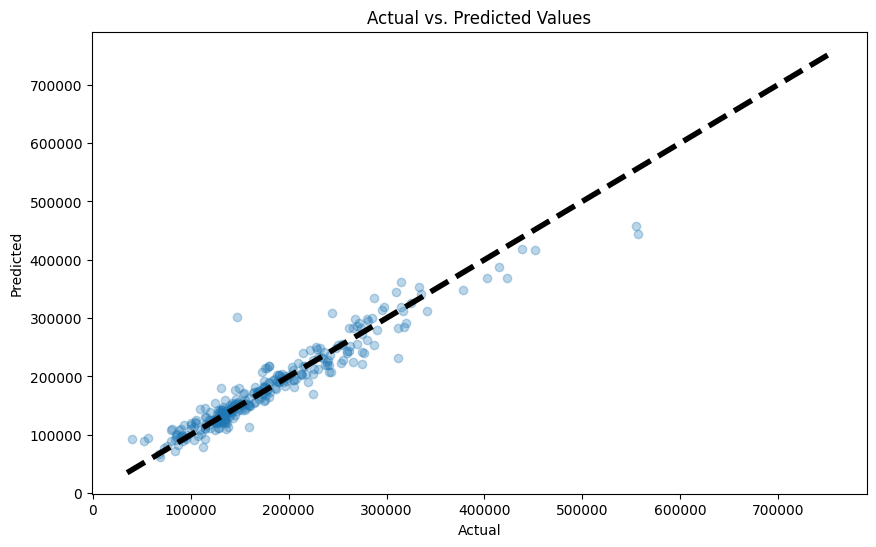

In [ ]:
# Actual vs. Predicted Values Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

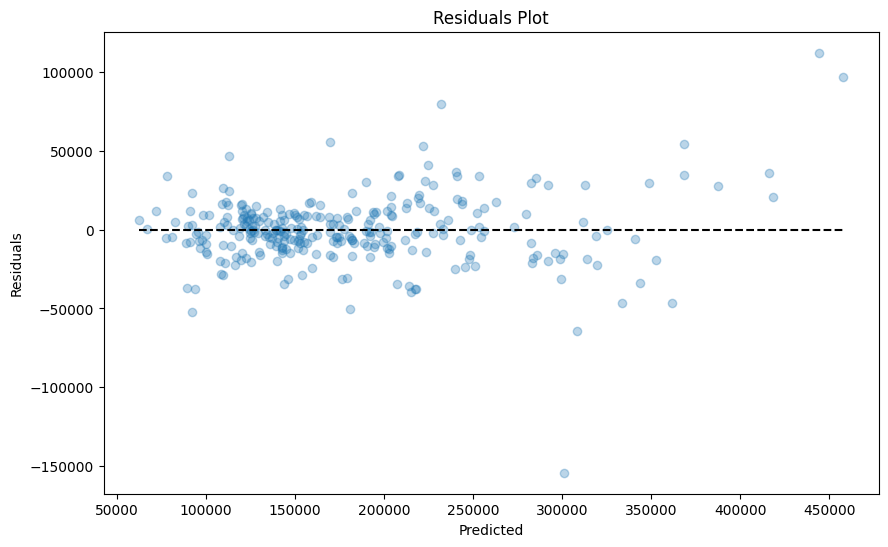

In [ ]:
# Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='k', linestyles='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

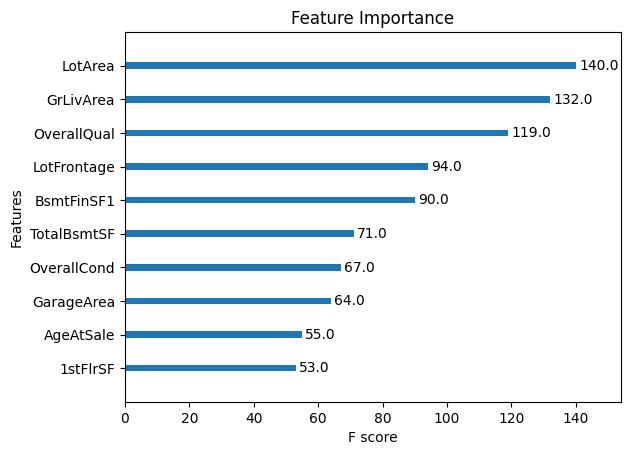

In [ ]:
xgb.plot_importance(model, max_num_features=10)
plt.title('Feature Importance')
plt.grid(False)
plt.show()

In [ ]:
explainer = shap.TreeExplainer(model, X_train)
shap_values = explainer(X_test)

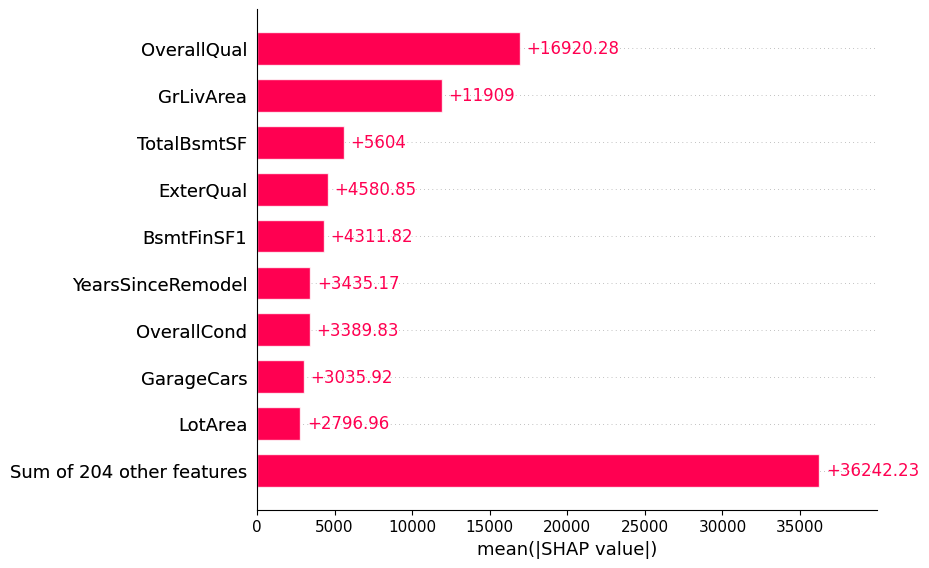

In [ ]:
shap.plots.bar(shap_values)

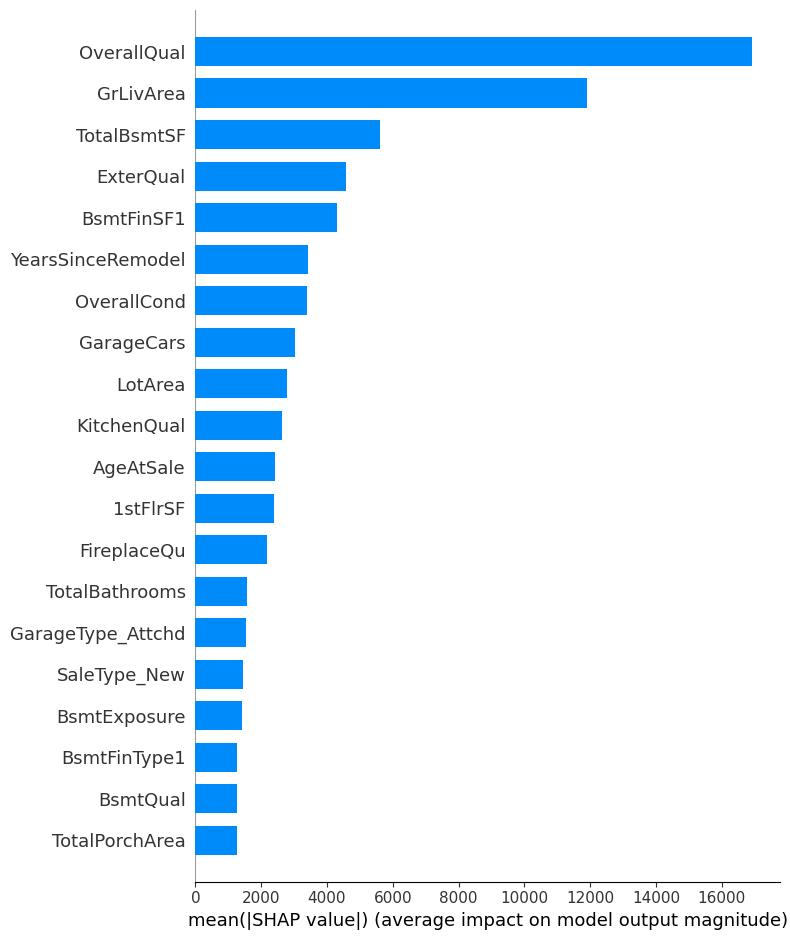

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

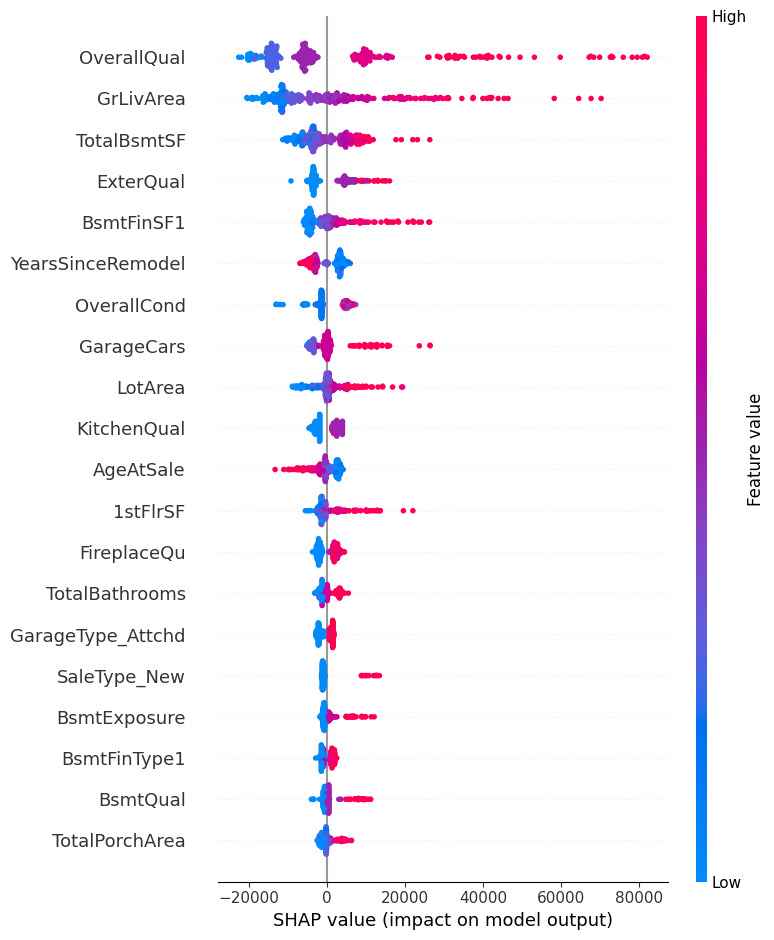

In [ ]:
shap.summary_plot(shap_values)

<ipython-input-37-20a4867dff46>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_shap_df['Feature'] = significant_shap_df['Feature'].map(lambda x: neighborhood_descriptions.get(x, x))
<ipython-input-37-20a4867dff46>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SHAP_Value', y='Feature', data=significant_shap_df, palette=colors, alpha=0.6)


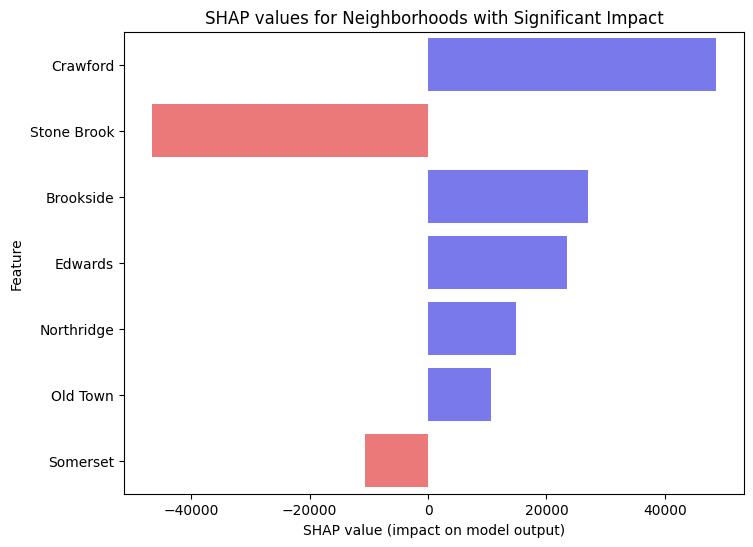

In [ ]:
# Mapping from Neighborhood codes to descriptions
neighborhood_descriptions = {
    'Neighborhood_Blmngtn': 'Bloomington Heights',
    'Neighborhood_Blueste': 'Bluestem',
    'Neighborhood_BrDale': 'Briardale',
    'Neighborhood_BrkSide': 'Brookside',
    'Neighborhood_ClearCr': 'Clear Creek',
    'Neighborhood_CollgCr': 'College Creek',
    'Neighborhood_Crawfor': 'Crawford',
    'Neighborhood_Edwards': 'Edwards',
    'Neighborhood_Gilbert': 'Gilbert',
    'Neighborhood_IDOTRR': 'Iowa DOT and Rail Road',
    'Neighborhood_MeadowV': 'Meadow Village',
    'Neighborhood_Mitchel': 'Mitchell',
    'Neighborhood_NAmes': 'North Ames',
    'Neighborhood_NoRidge': 'Northridge',
    'Neighborhood_NPkVill': 'Northpark Villa',
    'Neighborhood_NridgHt': 'Northridge Heights',
    'Neighborhood_NWAmes': 'Northwest Ames',
    'Neighborhood_OldTown': 'Old Town',
    'Neighborhood_SWISU': 'South & West of Iowa State University',
    'Neighborhood_Sawyer': 'Sawyer',
    'Neighborhood_SawyerW': 'Sawyer West',
    'Neighborhood_Somerst': 'Somerset',
    'Neighborhood_StoneBr': 'Stone Brook',
    'Neighborhood_Timber': 'Timberland',
    'Neighborhood_Veenker': 'Veenker'
}

# Get the feature names that start with 'Neighborhood'
feature_names = [feature for feature in X_test.columns if feature.startswith('Neighborhood')]

# Get the indexes of these features
feature_indexes = [X_test.columns.get_loc(name) for name in feature_names]

# Sum the SHAP values across all samples for each of the selected features
neighborhood_shap_values = shap_values[:, feature_indexes].values.sum(axis=0)

# Convert SHAP values to a DataFrame for easier manipulation
shap_df = pd.DataFrame({'Feature': feature_names, 'SHAP_Value': neighborhood_shap_values})

# Set a threshold for significant impact, e.g., SHAP value absolute greater than 10000
threshold = 10000
significant_shap_df = shap_df[abs(shap_df['SHAP_Value']) > threshold]

significant_shap_df['Feature'] = significant_shap_df['Feature'].map(lambda x: neighborhood_descriptions.get(x, x))

# Sort the DataFrame based on the absolute SHAP value to display highest impact features first
significant_shap_df = significant_shap_df.reindex(significant_shap_df.SHAP_Value.abs().sort_values(ascending=False).index)

textstr = '\n'.join([f"{v}" for _, v in neighborhood_descriptions.items()])
props = dict(boxstyle='round', facecolor='teal', alpha=0.5)

colors = ['red' if x < 0 else 'blue' for x in significant_shap_df['SHAP_Value']]

# Create the bar plot for significant SHAP values
plt.figure(figsize=(8, 6))
sns.barplot(x='SHAP_Value', y='Feature', data=significant_shap_df, palette=colors, alpha=0.6)
plt.xlabel('SHAP value (impact on model output)')
plt.title('SHAP values for Neighborhoods with Significant Impact')
# Place a text box in upper left in axes coords
# plt.gca().text(1.02, 0.61, textstr, transform=plt.gca().transAxes, fontsize=9, verticalalignment='top', bbox=props)
plt.show()

<ipython-input-38-cbff2524d56e>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_shap_df['Feature'] = significant_shap_df['Feature'].map(lambda x: mssubclass_descriptions.get(x, x))
<ipython-input-38-cbff2524d56e>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SHAP_Value', y='Feature', data=significant_shap_df, palette=colors, alpha=0.6)


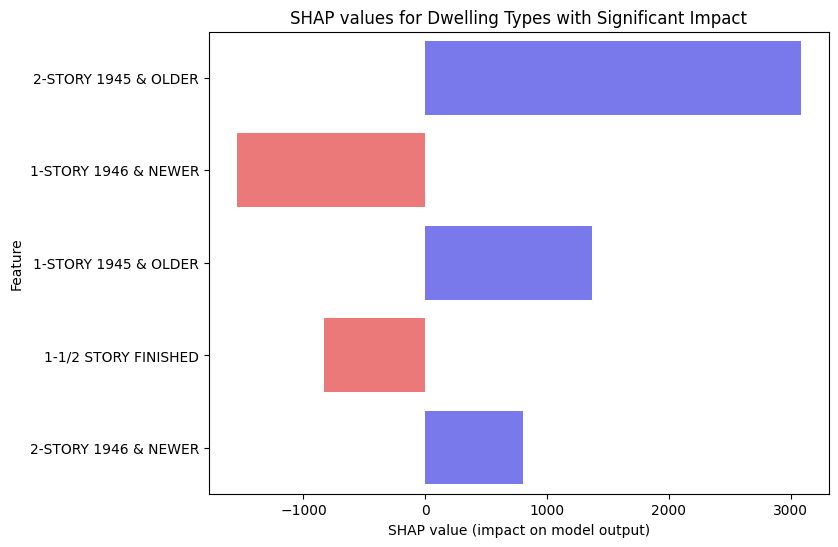

In [ ]:
# Mapping from MSSubClass codes to descriptions
mssubclass_descriptions = {
    'MSSubClass_20': '1-STORY 1946 & NEWER',
    'MSSubClass_30': '1-STORY 1945 & OLDER',
    'MSSubClass_40': '1-STORY W/FINISHED ATTIC ALL AGES',
    'MSSubClass_45': '1-1/2 STORY - UNFINISHED ALL AGES',
    'MSSubClass_50': '1-1/2 STORY FINISHED',
    'MSSubClass_60': '2-STORY 1946 & NEWER',
    'MSSubClass_70': '2-STORY 1945 & OLDER',
    'MSSubClass_75': '2-1/2 STORY ALL AGES',
    'MSSubClass_80': 'SPLIT OR MULTI-LEVEL',
    'MSSubClass_85': 'SPLIT FOYER',
    'MSSubClass_90': 'DUPLEX - ALL STYLES AND AGES',
    'MSSubClass_120': '1-STORY PUD 1946 & NEWER',
    'MSSubClass_150': '1-1/2 STORY PUD - ALL AGES',
    'MSSubClass_160': '2-STORY PUD - 1946 & NEWER',
    'MSSubClass_180': 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
    'MSSubClass_190': '2 FAMILY CONVERSION - ALL STYLES AND AGES'
}

# Get the feature names that start with 'MSSubClass'
feature_names = [feature for feature in X_test.columns if feature.startswith('MSSubClass')]

# Get the indexes of these features
feature_indexes = [X_test.columns.get_loc(name) for name in feature_names]

# Sum the SHAP values across all samples for each of the selected features
neighborhood_shap_values = shap_values[:, feature_indexes].values.sum(axis=0)

# Convert SHAP values to a DataFrame for easier manipulation
shap_df = pd.DataFrame({'Feature': feature_names, 'SHAP_Value': neighborhood_shap_values})

# Set a threshold for significant impact, e.g., SHAP value absolute greater than 10000
threshold = 0
significant_shap_df = shap_df[abs(shap_df['SHAP_Value']) > threshold]

significant_shap_df['Feature'] = significant_shap_df['Feature'].map(lambda x: mssubclass_descriptions.get(x, x))

# Sort the DataFrame based on the absolute SHAP value to display highest impact features first
significant_shap_df = significant_shap_df.reindex(significant_shap_df.SHAP_Value.abs().sort_values(ascending=False).index)

textstr = '\n'.join([f"{v}" for _, v in mssubclass_descriptions.items()])
props = dict(boxstyle='round', facecolor='teal', alpha=0.5)

colors = ['red' if x < 0 else 'blue' for x in significant_shap_df['SHAP_Value']]

# Create the bar plot for significant SHAP values
plt.figure(figsize=(8, 6))
sns.barplot(x='SHAP_Value', y='Feature', data=significant_shap_df, palette=colors, alpha=0.6)
plt.xlabel('SHAP value (impact on model output)')
plt.title('SHAP values for Dwelling Types with Significant Impact')
# Place a text box in upper left in axes coords
# plt.gca().text(1.02, 0.52, textstr, transform=plt.gca().transAxes, fontsize=9, verticalalignment='top', bbox=props)
plt.show()

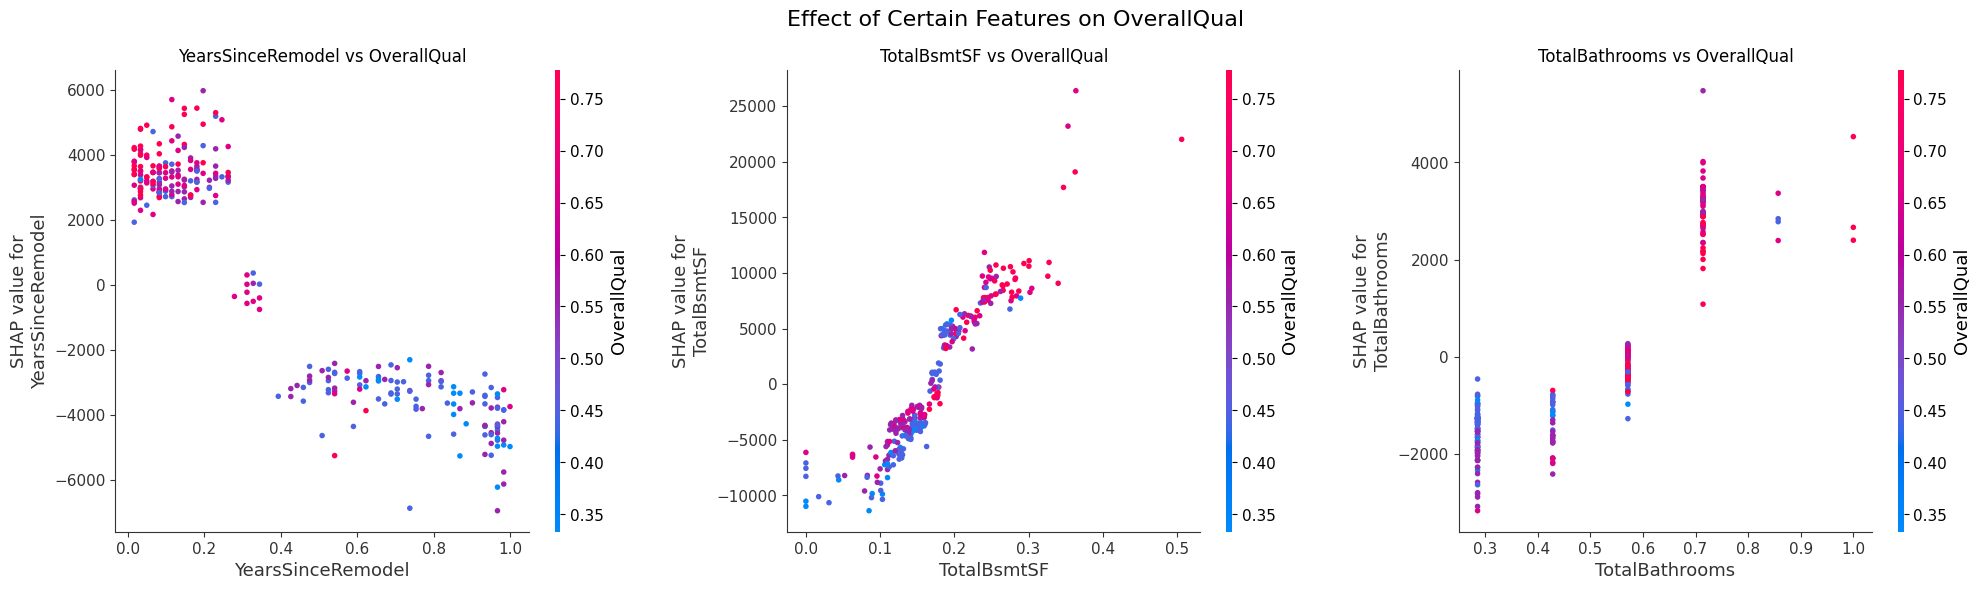

In [ ]:
# Setup the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
plt.subplots_adjust(wspace=0.3)  # Adjust horizontal spacing
fig.suptitle('Effect of Certain Features on OverallQual', fontsize=16)

# Create dependence plots manually
# For "YearsSinceRemodel"
shap.dependence_plot(
    "YearsSinceRemodel",
    shap_values.values,
    X_test,
    interaction_index="OverallQual",
    ax=axes[0],  # First subplot
    show=False   # Prevent it from showing immediately
)
axes[0].set_title("YearsSinceRemodel vs OverallQual")

# For "TotalBsmtSF"
shap.dependence_plot(
    "TotalBsmtSF",
    shap_values.values,
    X_test,
    interaction_index="OverallQual",
    ax=axes[1],  # Second subplot
    show=False   # Prevent it from showing immediately
)
axes[1].set_title("TotalBsmtSF vs OverallQual")

# For "TotalBathrooms"
shap.dependence_plot(
    "TotalBathrooms",
    shap_values.values,
    X_test,
    interaction_index="OverallQual",
    ax=axes[2],  # Third subplot
    show=False   # Prevent it from showing immediately
)
axes[2].set_title("TotalBathrooms vs OverallQual")

# Show the plots
plt.show()

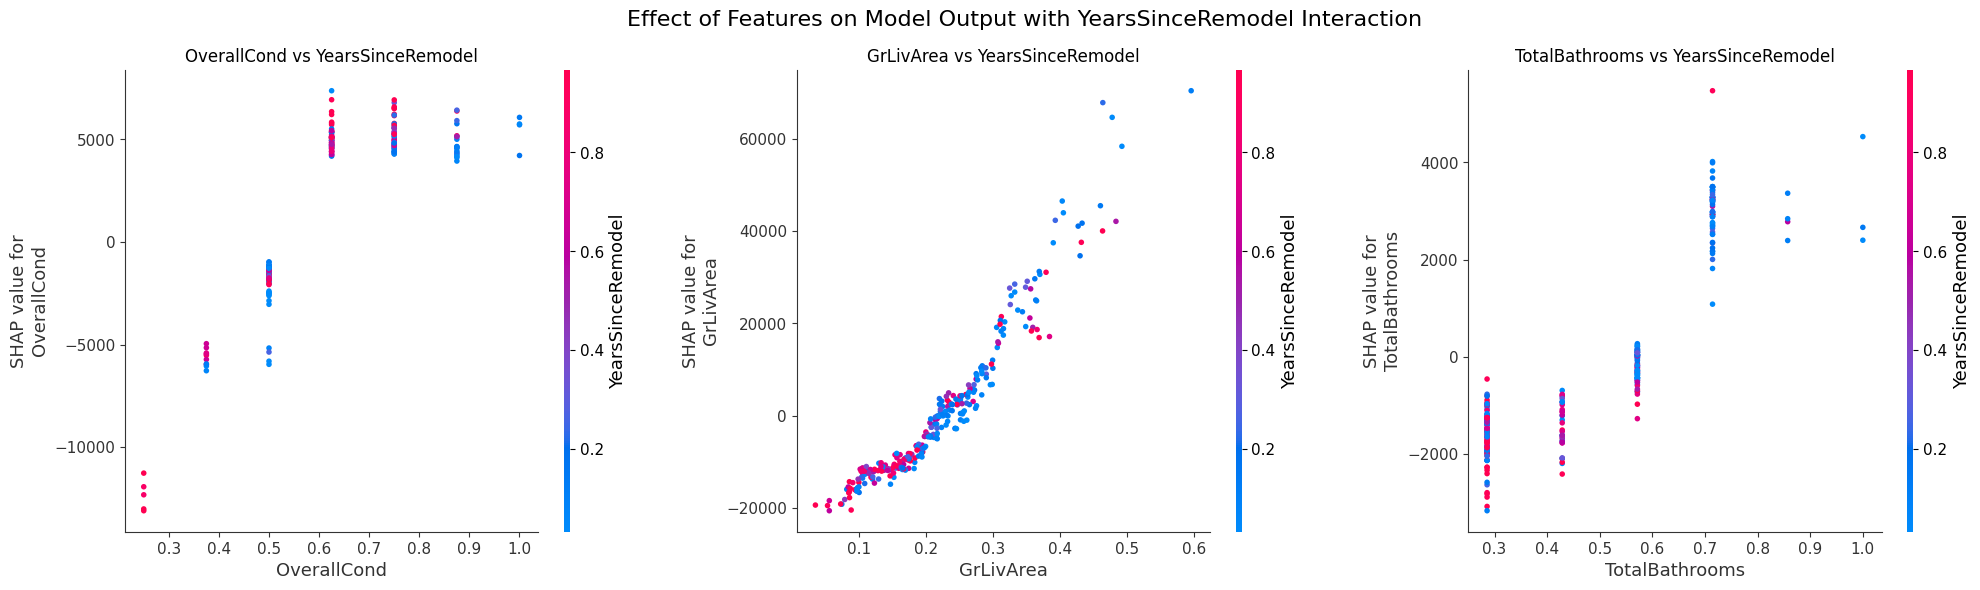

In [ ]:
# Setup the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))  # One row, three columns
plt.subplots_adjust(wspace=0.3)  # Adjust horizontal spacing
fig.suptitle('Effect of Features on Model Output with YearsSinceRemodel Interaction', fontsize=16)

# Creating a dependence plot for 'OverallCond'
shap.dependence_plot(
    "OverallCond",  # Feature of interest
    shap_values.values,  # SHAP values computed
    X_test,  # Test dataset
    interaction_index="YearsSinceRemodel",  # Feature to color by for interaction effects
    ax=axes[0],  # First subplot
    show=False  # Prevent it from showing immediately
)
axes[0].set_title("OverallCond vs YearsSinceRemodel")

# Creating a dependence plot for 'GrLivArea'
shap.dependence_plot(
    "GrLivArea",  # Feature of interest
    shap_values.values,  # SHAP values computed
    X_test,  # Test dataset
    interaction_index="YearsSinceRemodel",  # Feature to color by for interaction effects
    ax=axes[1],  # Second subplot
    show=False  # Prevent it from showing immediately
)
axes[1].set_title("GrLivArea vs YearsSinceRemodel")

# Creating a dependence plot for 'TotalBathrooms'
shap.dependence_plot(
    "TotalBathrooms",  # Feature of interest
    shap_values.values,  # SHAP values computed
    X_test,  # Test dataset
    interaction_index="YearsSinceRemodel",  # Feature to color by for interaction effects
    ax=axes[2],  # Third subplot
    show=False  # Prevent it from showing immediately
)
axes[2].set_title("TotalBathrooms vs YearsSinceRemodel")

# Show the plots
plt.show()

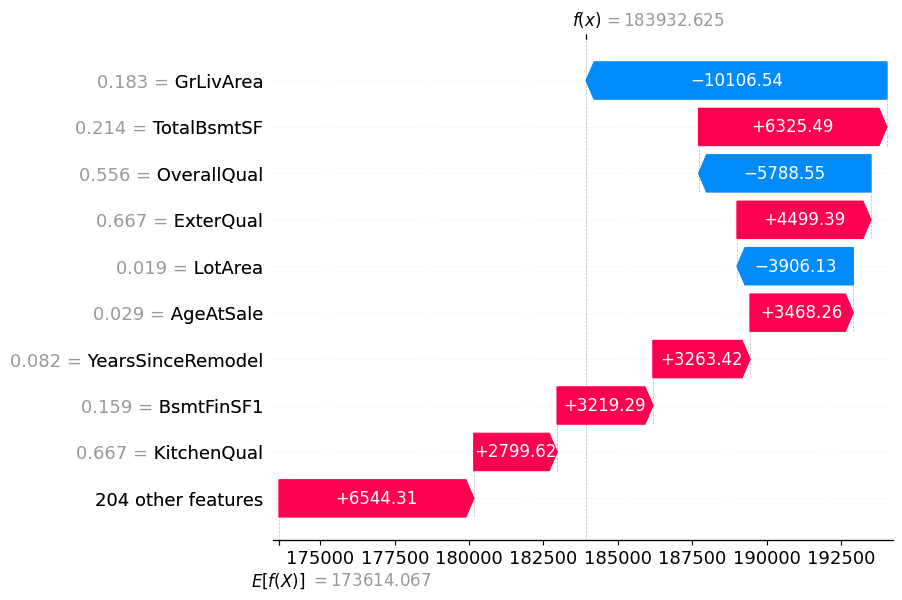

In [ ]:
# Waterfall plot for the first prediction
shap.plots.waterfall(shap_values[0])

##Selected features

In [ ]:
data = pd.read_csv(cleaned_norm_selected)
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

model = XGBRegressor(objective='reg:squarederror')

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Best parameters are as follows: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}

In [ ]:
# Initialize XGBoostRegressor
model = xgb.XGBRegressor(colsample_bytree= 1,
                        learning_rate= 0.1,
                        max_depth= 3,
                        n_estimators= 300,
                        subsample= 0.8,
                        objective='reg:squarederror')

# Train the model
model.fit(X_train, y_train)

# Use the best model to make predictions
y_pred = model.predict(X_test)

# Calculate R² - This is the coefficient of determination
r2 = r2_score(y_test, y_pred)

# Calculate RMSE - This is the root mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("XGBoost Performance:")
print(f'\nRMSE: {rmse:.3f}')
print(f'R² Score: {r2:.3f}')

XGBoost Performance:

RMSE: 23276.638
R² Score: 0.911


#CatBoost

##All features

In [ ]:
df = pd.read_csv(train)

df.drop(['Id', 'MSSubClass', 'MSZoning'], axis = 1, inplace = True)

df['AgeAtSale'] = df['YrSold'] - df['YearBuilt']
df['GarageAgeAtSale'] = df['YrSold'] - df['GarageYrBlt']
df['YearsSinceRemodel'] = df['YrSold'] - df['YearRemodAdd']
df['TotalBathrooms'] = df['FullBath'] + (0.5 * df['HalfBath'])
df['TotalBsmtBathrooms'] = df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath'])
df['TotalPorchArea'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

df.drop('YrSold', axis=1, inplace=True)
df.drop('YearBuilt', axis=1, inplace=True)
df.drop('GarageYrBlt', axis=1, inplace=True)
df.drop('YearRemodAdd', axis=1, inplace=True)
df.drop('FullBath', axis=1, inplace=True)
df.drop('HalfBath', axis=1, inplace=True)
df.drop('BsmtFullBath', axis=1, inplace=True)
df.drop('BsmtHalfBath', axis=1, inplace=True)
df.drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1, inplace=True)

X = df.drop('SalePrice', axis = 1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()

X_train[categorical_features] = X_train[categorical_features].fillna('missing')
X_test[categorical_features] = X_test[categorical_features].fillna('missing')

In [ ]:
## Hyperparamter grid for catboost
param_grid = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

model = cb.CatBoostRegressor(cat_features=categorical_features, loss_function='RMSE', verbose=100)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=3)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

predictions = best_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Mean Squared Error: {mse}')

# Best Parameters: {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [ ]:
# Initialize CatBoostRegressor
model = cb.CatBoostRegressor(iterations=1000,
                             learning_rate=0.1,
                             depth=6,
                             l2_leaf_reg = 1,
                             cat_features=categorical_features,
                             loss_function='RMSE',
                             verbose=100)

# Fit model
model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)

predictions = model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)

# Calculate R-squared
r_squared = r2_score(y_test, predictions)

print("CatBoost Performance:")
print(f'\nRMSE: {rmse:.3f}')
print(f'R² Score: {r2:.3f}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 72549.4053693	test: 82762.9150792	best: 82762.9150792 (0)	total: 89.3ms	remaining: 1m 29s
100:	learn: 14660.4123264	test: 27320.4388498	best: 27320.4388498 (100)	total: 2.95s	remaining: 26.3s
200:	learn: 10548.0396042	test: 26521.5189641	best: 26521.5189641 (200)	total: 6.26s	remaining: 24.9s
300:	learn: 8261.2572257	test: 26212.5973436	best: 26212.5973436 (300)	total: 11.1s	remaining: 25.7s
400:	learn: 6756.6854403	test: 26090.9882236	best: 26072.9422608 (398)	total: 17.3s	remaining: 25.9s
500:	learn: 5655.4221967	test: 25999.2321027	best: 25989.7288790 (494)	total: 21.3s	remaining: 21.2s
600:	learn: 4739.9359645	test: 25978.4301944	best: 25937.0072392 (589)	total: 25.3s	remaining: 16.8s
700:	learn: 3996.9588540	test: 25970.6133583	best: 25937.0072392 (589)	total: 28.3s	remaining: 12.1s
800:	learn: 3408.1473870	test: 25975.4272417	best: 25937.0072392 (589)	total: 31.4s	remaining: 7.79s
900:	learn: 2979.3457725	test: 25995.1719251	best: 25937.0072392 (589)	total: 35.4s	remain

# Ensemble Model

## All features

In [ ]:
data = pd.read_csv(cleaned_norm)
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Averaging out predictions

In [ ]:
# Fitting the models

# XGBoost model
xgb_model = xgb.XGBRegressor(
    colsample_bytree= 1,
    learning_rate= 0.05,
    max_depth= 3,
    n_estimators= 300,
    subsample= 0.8,
    objective='reg:squarederror'
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)


# SVM Model
svm_model = SVR(kernel='linear', C=100, gamma= 'scale')

# Fit the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)


# RF Model
rf_model = RandomForestRegressor(max_depth=15, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)


# Stack the predictions into a matrix where each column represents a model's predictions
predictions = np.column_stack((y_pred_xgb, y_pred_svm, y_pred_rf))

# Calculate the average predictions across all models for each instance
average_predictions = np.mean(predictions, axis=1)

# Calculate RMSE
rmse = mean_squared_error(y_test, average_predictions, squared=False)

# Calculate R-squared
r_squared = r2_score(y_test, average_predictions)

print("Ensemble Model Performance:")
print(f'\nRMSE: {rmse:.3f}')
print(f'R² Score: {r_squared:.3f}')

Ensemble Model Performance:

RMSE: 28927.586
R² Score: 0.863


### Stacking technique

In [ ]:
# Define the base learners
estimators = [
    ('xgb', xgb.XGBRegressor(colsample_bytree=1, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8, objective='reg:squarederror')),
    ('svm', SVR(kernel='linear', C=100, gamma='scale')),
    ('rf', RandomForestRegressor(max_depth=15, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42))
]

# Initialize the StackingRegressor
stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5
)

# Fit the stack model
stack_model.fit(X_train, y_train)

# Make predictions
y_pred_stack = stack_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_stack))

# Calculate R-squared
r_squared = r2_score(y_test, y_pred_stack)

print("Stacking Model Performance:")
print(f'\nRMSE: {rmse:.3f}')
print(f'R² Score: {r_squared:.3f}')

Stacking Model Performance:

RMSE: 22617.215
R² Score: 0.916


### Stacking with Hyperparameter tuning

In [ ]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'xgb__n_estimators': [100, 300, 500],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.7, 0.8, 0.9]
}

# Initialize the GridSearchCV object for XGBoost
xgb_grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'), param_grid=xgb_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Fit the grid search to the data
xgb_grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best XGBoost parameters:", xgb_grid_search.best_params_)
print("Best XGBoost model:", xgb_grid_search.best_estimator_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.7; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.9; total time=   2.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:47:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.7; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.7; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.9; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.7; total time=   1.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.9; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.9; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.7; total time=   1.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:48:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.7; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.9; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=500, xgb__subsample=0.9; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.7; total time=   2.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.7; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.8; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.8; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=100, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:49:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:50:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:50:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.9; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:50:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.9; total time=   1.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:50:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.9; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:50:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:50:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:50:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:50:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:50:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:50:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.8; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:50:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:50:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:50:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=500, xgb__subsample=0.9; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:50:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.7}
Best XGBoost model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [ ]:
# Define the parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale'],
    'kernel': ['linear', 'rbf']
}

# Initialize the GridSearchCV object for SVM
svm_grid_search = GridSearchCV(estimator=SVR(), param_grid=svm_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Fit the grid search to the data
svm_grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best SVM parameters:", svm_grid_search.best_params_)
print("Best SVM model:", svm_grid_search.best_estimator_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   0.2s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.4s
[CV] END .......................C=1, gamma=scale,

In [ ]:
# Define the base learners with the optimized parameters
estimators = [
    ('xgb', xgb.XGBRegressor(**{k.replace('xgb__', ''): v for k, v in xgb_grid_search.best_params_.items()})),
    ('svm', SVR(**{k.replace('svm__', ''): v for k, v in svm_grid_search.best_params_.items()})),
    ('rf', RandomForestRegressor(max_depth=15, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42))
]

# Reinitialize and fit the StackingRegressor with the tuned models
stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5
)
stack_model.fit(X_train, y_train)
y_pred_stack = stack_model.predict(X_test)

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_stack))

# Calculate R-squared
r_squared = r2_score(y_test, y_pred_stack)

print("Stacking Model Performance with Hyperparameter Tuning:")
print(f'\nRMSE: {rmse:.3f}')
print(f'R² Score: {r_squared:.3f}')

RMSE: 22446.624003921766
R-squared: 0.9174891303636429
